[exercises](brir.ipynb)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import soundfile as sf
import tools

In [2]:
brir_clap, clap_fs = sf.read('data/brir_clap.wav')
clap_fs

44100

In [3]:
brir_clap.shape

(45998, 2)

In [4]:
len(brir_clap) / clap_fs  # duration in seconds

1.0430385487528344

In [5]:
mat_contents = loadmat('data/brir_sweep.mat',
                       struct_as_record=False, squeeze_me=True)
mat_contents['__header__']

b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue May 07 11:52:13 2013'

In [6]:
data = mat_contents['data']
type(data)

scipy.io.matlab._mio5_params.mat_struct

In [7]:
data.SystemLatencySamples, data.SystemlatencyRemoved

(2167, 'YES')

In [8]:
sweep_fs = data.fs
assert sweep_fs == clap_fs
sweep_fs

44100

In [9]:
data.head_azimuth

0

In [10]:
brir_sweep = data.ir
brir_sweep.shape

(66150, 2)

In [11]:
len(brir_sweep) / sweep_fs  # duration in seconds

1.5

In [12]:
speech, speech_fs = sf.read('data/xmas.wav')
speech.shape

(114400,)

In [13]:
assert speech_fs == clap_fs == sweep_fs
fs = speech_fs

In [14]:
def convolve_multichannel_ir(x, h, **kwargs):
    """Convolve mono signal x with multichannel impulse reponse h.

    After the convolution, the result is normalized to the maximum
    amplitude of x.    

    """
    x = np.squeeze(np.asarray(x))
    if x.ndim != 1:
        raise ValueError("x must be a mono signal")

    h = np.asarray(h)
    if h.ndim == 1:
        h = h.reshape(-1, 1)

    y = signal.fftconvolve(x[:, np.newaxis], h, mode='full', axes=0)
    y = tools.normalize(y, np.max(np.abs(x)))

    return y

In [15]:
speech_clap = convolve_multichannel_ir(speech, brir_clap)
speech_clap.shape

(160397, 2)

In [16]:
speech_sweep = convolve_multichannel_ir(speech, brir_sweep)

In [17]:
sf.write('data/xmas_brir_clap.wav', speech_clap, fs)
sf.write('data/xmas_brir_sweep.wav', speech_sweep, fs)

<audio src="data/xmas.wav" controls></audio>
[data/xmas.wav](data/xmas.wav)

<audio src="data/xmas_brir_clap.wav" controls></audio>
[data/xmas_brir_clap.wav](data/xmas_brir_clap.wav)

<audio src="data/xmas_brir_sweep.wav" controls></audio>
[data/xmas_brir_sweep.wav](data/xmas_brir_sweep.wav)


In [18]:
hcomp, hcomp_fs = sf.read('data/THOMSON_HED415N_KEMAR_hcomp.wav')
assert hcomp_fs == fs
hcomp.shape

(512, 2)

In [19]:
def compensate(brir):
    """Apply headphone compensation to a BRIR.

    Side note: The variable "hcomp" is taken from the global scope
    (it is *not* a function argument)!

    """
    return signal.fftconvolve(brir, hcomp, mode='full', axes=0)

In [20]:
brir_clap_hcomp = compensate(brir_clap)
brir_sweep_hcomp = compensate(brir_sweep)

In [21]:
speech_clap_hcomp = convolve_multichannel_ir(speech, brir_clap_hcomp)
speech_sweep_hcomp = convolve_multichannel_ir(speech, brir_sweep_hcomp)

In [22]:
sf.write('data/xmas_brir_clap_hcomp.wav', speech_clap_hcomp, fs)
sf.write('data/xmas_brir_sweep_hcomp.wav', speech_sweep_hcomp, fs)

<audio src="data/xmas.wav" controls></audio>
[data/xmas.wav](data/xmas.wav)

<audio src="data/xmas_brir_clap.wav" controls></audio>
[data/xmas_brir_clap.wav](data/xmas_brir_clap.wav)

<audio src="data/xmas_brir_clap_hcomp.wav" controls></audio>
[data/xmas_brir_clap_hcomp.wav](data/xmas_brir_clap_hcomp.wav)

---

<audio src="data/xmas.wav" controls></audio>
[data/xmas.wav](data/xmas.wav)

<audio src="data/xmas_brir_sweep.wav" controls></audio>
[data/xmas_brir_sweep.wav](data/xmas_brir_sweep.wav)

<audio src="data/xmas_brir_sweep_hcomp.wav" controls></audio>
[data/xmas_brir_sweep_hcomp.wav](data/xmas_brir_sweep_hcomp.wav)

---

Note that the headphone compensation filter used here was designed for THOMSON HED415N headphones.
If you use any other type of headphones, the result might not sound better, it might even sound worse!

In [23]:
# TODO: plot BRIRs

In [24]:
# TODO: estimate time-of-flight

In [25]:
# TODO: estimate SNR

In [26]:
# TODO: plot frequency response

In [27]:
def load_ir_from_mat(angle):
    filename = 'data/brir_sweep{:+03d}.mat'.format(angle)
    data = loadmat(filename, struct_as_record=False, squeeze_me=True)['data']
    assert data.fs == fs
    assert np.isclose(np.rad2deg(data.head_azimuth), angle)
    return data.ir

In [28]:
angles = -80, -40, 40, 80
brirs = {angle: load_ir_from_mat(angle) for angle in angles}

In [29]:
brirs_hcomp = {angle: compensate(ir) for angle, ir in brirs.items()}

In [30]:
speech_hcomp = {angle: convolve_multichannel_ir(speech, ir)
                for angle, ir in brirs_hcomp.items()}

<audio src="data/xmas.wav" controls></audio>
[data/xmas.wav](data/xmas.wav)

<audio src="data/xmas_brir_sweep_hcomp-80.wav" controls></audio>
[data/xmas_brir_sweep_hcomp-80.wav](data/xmas_brir_sweep_hcomp-80.wav)

<audio src="data/xmas_brir_sweep_hcomp-40.wav" controls></audio>
[data/xmas_brir_sweep_hcomp-40.wav](data/xmas_brir_sweep_hcomp-40.wav)

<audio src="data/xmas_brir_sweep_hcomp.wav" controls></audio>
[data/xmas_brir_sweep_hcomp.wav](data/xmas_brir_sweep_hcomp.wav)

<audio src="data/xmas_brir_sweep_hcomp+40.wav" controls></audio>
[data/xmas_brir_sweep_hcomp+40.wav](data/xmas_brir_sweep_hcomp+40.wav)

<audio src="data/xmas_brir_sweep_hcomp+80.wav" controls></audio>
[data/xmas_brir_sweep_hcomp+80.wav](data/xmas_brir_sweep_hcomp+80.wav)

In [31]:
# TODO: plot impulse responses of 1 ear for all angles

In [32]:
# TODO: plot magnitude spectra

In the top right is the angle of the loudspeaker, relative to the head.

In [33]:
import io
from urllib.request import urlopen

url = 'https://zenodo.org/record/4459911/files/QU_KEMAR_anechoic_2m.mat'
file = io.BytesIO(urlopen(url).read())

# if you want to load a local file instead:
#file = "QU_KEMAR_anechoic_2m.mat"

In [34]:
irs = loadmat(file, struct_as_record=False, squeeze_me=True)['irs']

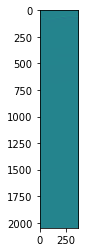

In [35]:
plt.imshow(irs.left)

What?

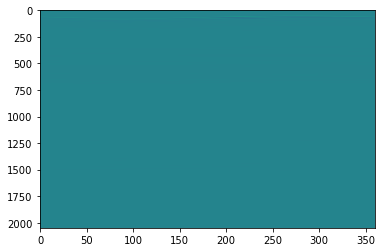

In [36]:
plt.imshow(irs.left, aspect='auto')

Better, but still: what?

Let's try to convert the values to decibels:

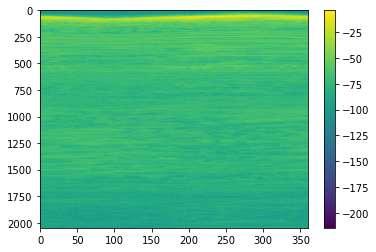

In [37]:
plt.imshow(20 * np.log10(np.abs(irs.left)), aspect='auto')
plt.colorbar()

OK, we're getting somewhere, but there are still things to do:

* replace x- and y-indices with meaningful values

* axis labels

* use one of the perceptually optimized colormaps: `viridis` (default), `plasma`, `inferno`, `magma`, `cividis`

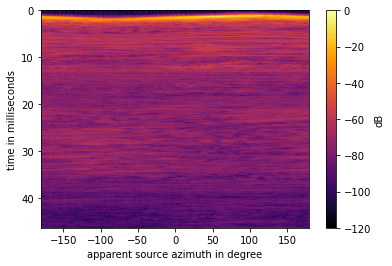

In [48]:
def plot_irs(samples):
    extent = [np.rad2deg(irs.apparent_azimuth[0]),
              np.rad2deg(irs.apparent_azimuth[-1]),
              len(irs.left[:samples]) * 1000 / irs.fs,
              0]
    plt.imshow(20 * np.log10(np.abs(irs.left[:samples])), aspect='auto',
               vmax=0, vmin=-120,
               cmap='inferno', extent=extent)
    plt.xlabel("apparent source azimuth in degree")
    plt.ylabel("time in milliseconds")
    cbar = plt.colorbar()
    cbar.set_label('dB', rotation=90)

plot_irs(-1)

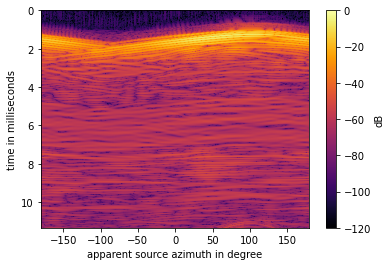

In [49]:
plot_irs(500)

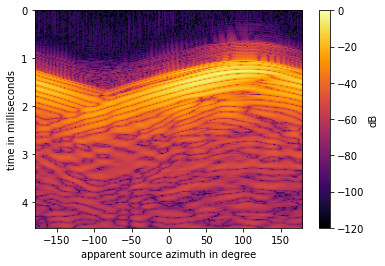

In [50]:
plot_irs(200)

In [41]:
# TODO: waterfall diagrams?

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>